In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.

set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### 병렬 노드 실행을 위한 분기 생성 방법

병렬노드를 실행하고 컨트롤 하는 방법입니다.  
  
동시다발 적으로 여러 프로세스를 구성하고 한 번에 처리하도록 합니다.  
  
fan-out(확장) 과 fan-in(수집) 이라고 합니다. 

In [3]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 A부터 D까지 생성 및 값 할당
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# 노드 연결
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

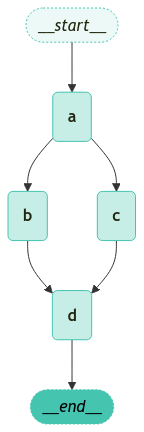

In [4]:
from graphs import visualize_graph

visualize_graph(graph)

리듀서를 통해 각 노드에 추가된 값들을 확인합니다.

In [5]:
# 그래프 실행
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e3b5150c-74aa-4f92-9f3b-02f9b03c8c28')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e3b5150c-74aa-4f92-9f3b-02f9b03c8c28')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e3b5150c-74aa-4f92-9f3b-02f9b03c8c28'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f522377e-64c0-4577-b63e-7b611eaae910'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='62eade03-785b-432a-b74e-ac6a30a32b1d')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e3b5150c-74aa-4f92-9f3b-02f9b03c8c28'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f522377e-64c0-4577-b63e-7b611eaae910'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='62eade03-785b-432a-b74e-ac6a30a32b1d'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='85f9fd03-fa56-4ac1-8519-8333e2e05476')]}

#### 병렬처리 중 예외 발생 대응

만약 병렬 처리 중 오류가 발생하게 된다면, 'superstep' 이 트랜젝션으로 실행되게 되는데, 이때 상태에 대한 것이 분기 실행이 동시에 되더라도 어딘가 에러가 발생하면 상태 업데이트가 되지 않습니다.  

- 노드 내에서 일반적인 Python 코드를 작성하여 예외를 포착하고 처리할 수 있습니다.
- `retry_policy` 를 설정하여 특정 유형의 예외가 발생한 노드를 재시도하도록 그래프를 지시할 수 있습니다. 실패한 분기만 재시도되므로 불필요한 작업 수행에 대해 걱정할 필요가 없습니다.

#### 추가 단계가 있는 병렬 노드의 fan-out 및 fan-in

병렬 처리 단계에서 노드가 여러개였을때 처리를 하는 방법입니다.  

In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# 노드 값 반환 클래스
class ReturnNodeValue:
    # 초기화
    def __init__(self, node_secret: str):
        self._value = node_secret

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)

# 노드 생성 및 연결
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# 그래프 컴파일
graph = builder.compile()

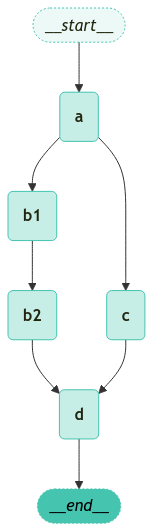

In [7]:
from graphs import visualize_graph

visualize_graph(graph)

In [8]:
# 빈 리스트를 사용한 그래프 집계 연산 실행, 모든 데이터에 대한 기본 집계 수행
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='13cc0aef-3cd9-46ce-95a2-7bc3fca11764')]
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='13cc0aef-3cd9-46ce-95a2-7bc3fca11764')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='13cc0aef-3cd9-46ce-95a2-7bc3fca11764'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='f324c422-285b-44e7-ac7c-c3a50f051bd7'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='d54b0b5d-1471-4847-8080-d0c969b3cbab')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='13cc0aef-3cd9-46ce-95a2-7bc3fca11764'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='f324c422-285b-44e7-ac7c-c3a50f051bd7'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='d54b0

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='13cc0aef-3cd9-46ce-95a2-7bc3fca11764'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='f324c422-285b-44e7-ac7c-c3a50f051bd7'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='d54b0b5d-1471-4847-8080-d0c969b3cbab'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='ca2ff7eb-102a-47d6-8842-23916c2a2c0a'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='a499d2c7-691e-4a3d-98ed-a278a7350e28')]}

#### 조건부 분기(conditional branching)

fan-out 이 결정적이지 않은 경우, `add_conditional_edge` 를 직접 사용할 수 있습니다.

In [9]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph


# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# 노드별 고유 값을 반환하는 클래스
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# 상태 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# 상태의 'which' 값에 따른 조건부 라우팅 경로 결정 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 전체 병렬 처리할 노드 목록
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


# 최종 노드 연결 및 그래프 컴파일
builder.add_edge("e", END)
graph = builder.compile()

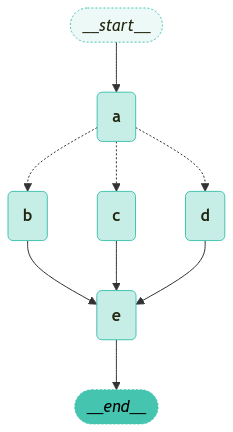

In [11]:
from graphs import visualize_graph

visualize_graph(graph)

In [12]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='690753b8-b4dc-4126-9e3f-7ec9d6889247')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='690753b8-b4dc-4126-9e3f-7ec9d6889247')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='690753b8-b4dc-4126-9e3f-7ec9d6889247'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='2f2c986c-79fa-4672-ae58-865450151521'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='cb6c5959-5325-48cf-9d87-08302bfe2925')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='690753b8-b4dc-4126-9e3f-7ec9d6889247'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='2f2c986c-79fa-4672-ae58-865450151521'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='cb6c5959-5325-48cf-9d87-08302bfe2925'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='9a970812-e006-41fa-aa7c-49364e93c6f5')],
 'which': 'bc'}

In [13]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ee73a74a-bebb-4a81-947f-f2da0f476ad0')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ee73a74a-bebb-4a81-947f-f2da0f476ad0')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ee73a74a-bebb-4a81-947f-f2da0f476ad0'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='00b83546-9d31-4c4c-8d17-676891f0fe14'), HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='d35bb913-c82a-4fdd-9b53-2382d6d84e87')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='ee73a74a-bebb-4a81-947f-f2da0f476ad0'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='00b83546-9d31-4c4c-8d17-676891f0fe14'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='d35bb913-c82a-4fdd-9b53-2382d6d84e87'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='8dfe49c3-6a1a-4198-8ddb-56fc5df4acf8')],
 'which': 'cd'}

#### fan-out 값의 신뢰도에 따른 정렬

병렬로 펼쳐진 노드들은 하나의 "super-step"으로 실행됩니다. 각 super-step 에서 발생한 업데이트들은 해당 super-step 이 완료된 후 순차적으로 상태에 적용됩니다.  
  
병렬 super-step 에서 일관된 사전 정의된 업데이트 순서가 필요한 경우, 출력값을 식별 키와 함께 상태의 별도 필드에 기록한 다음, fan-out 된 각 노드에서 집결 지점까지 일반 edge 를 추가하여 "sink" 노드에서 이들을 결합해야 합니다.  
  
예를 들어, 병렬 단계의 출력을 "신뢰도"에 따라 정렬하고자 하는 경우를 고려해보겠습니다.  
  
결합할때 순서를 정할 수 있습니다.

In [14]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 팬아웃 값들의 병합 로직 구현, 빈 리스트 처리 및 리스트 연결 수행
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # 덮어쓰기
        return []
    return left + right


# 상태 관리를 위한 타입 정의, 집계 및 팬아웃 값 저장 구조 설정
class State(TypedDict):
    # add_messages 리듀서 사용
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


# 그래프 초기화
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


# 병렬 노드 값 반환 클래스
class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    # 호출시 상태 업데이트
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


# 신뢰도(reliability)가 다른 병렬 노드들 추가, 종합할때 순서를 정할 수 있다.
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


# 팬아웃 값들을 신뢰도 기준으로 정렬하고 최종 집계 수행
def aggregate_fanout_values(state: State) -> Any:
    # 신뢰도 기준 정렬
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# 집계 노드 추가
builder.add_node("e", aggregate_fanout_values)


# 상태에 따른 조건부 라우팅 로직 구현
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# 중간 노드들 설정 및 조건부 엣지 추가
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

# 중간 노드들과 최종 집계 노드 연결
for node in intermediates:
    builder.add_edge(node, "e")

# 그래프 완성을 위한 최종
graph = builder.compile()

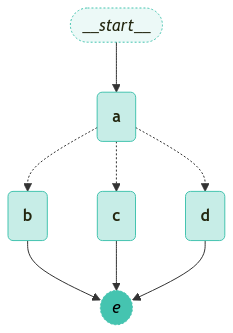

In [15]:
from graphs import visualize_graph

visualize_graph(graph)

병렬로 노드 실행시 결과를 reliability 기준으로 정렬합니다.

참고
- b: reliability=0.1
- c: reliability=0.9
- d: reliability=0.5

In [16]:
# 그래프 실행(which: bc 로 지정)
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f702b29a-7bd7-434b-a0ce-9af8735c167d')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f702b29a-7bd7-434b-a0ce-9af8735c167d')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='f702b29a-7bd7-434b-a0ce-9af8735c167d'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='558fa962-2f0f-4725-8a60-1deaf42a9737'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='31d57e16-51d8-4f40-9cb5-2eb88853bc06'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='a35920ef-d4b1-4627-880e-c039263e4d4a')],
 'fanout_values': [],
 'which': 'bc'}

In [17]:
# 그래프 실행(which: cd 로 지정)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='4efcaed3-b6ca-45c4-ad08-2db03f45542f')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='4efcaed3-b6ca-45c4-ad08-2db03f45542f')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='4efcaed3-b6ca-45c4-ad08-2db03f45542f'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='4f84d235-03a2-4f07-aad0-1a0fa13293ed'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='7a996042-efca-4328-8b26-c1e5d426a073'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='e30dd081-48d4-4f7a-842c-809eb4f359a2')],
 'fanout_values': [],
 'which': 'cd'}